# Alzheimers Detection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import cv2
from distutils.dir_util import copy_tree, remove_tree
import warnings

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model 
from imblearn.over_sampling import SMOTE
from random import randint
from keras import regularizers
from keras.layers import Dropout

In [3]:
default_dir = '/Users/rounaksarkar/Downloads/deskTop/ML:AI/4. Computer Vision Projects/Alzheimer Detection/Alzheimer_s Dataset/'
root_dir = '/Users/rounaksarkar/Downloads/deskTop/ML:AI/4. Computer Vision Projects/Alzheimer Detection/'
train_dir = default_dir + 'train/'
test_dir = default_dir + 'test/'
work_dir = root_dir + 'Model/'

if os.path.exists(work_dir):
    remove_tree(work_dir)

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents: ", os.listdir(work_dir))

Working Directory Contents:  ['VeryMildDemented', 'ModerateDemented', 'MildDemented', 'NonDemented']


In [4]:
CLASSES = ['VeryMildDemented', 'ModerateDemented', 'MildDemented', 'NonDemented']
IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [5]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

image_generator = ImageDataGenerator(rescale=1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode= FILL_MODE,
                                     horizontal_flip = HORZ_FLIP)

The ImageDataGenerator function generates batches of tensor image data with real-time data augmentation.

In [6]:
train_dataset = image_generator.flow_from_directory(batch_size=6500, directory=work_dir, target_size=(176,176), shuffle=True)

Found 6400 images belonging to 4 classes.


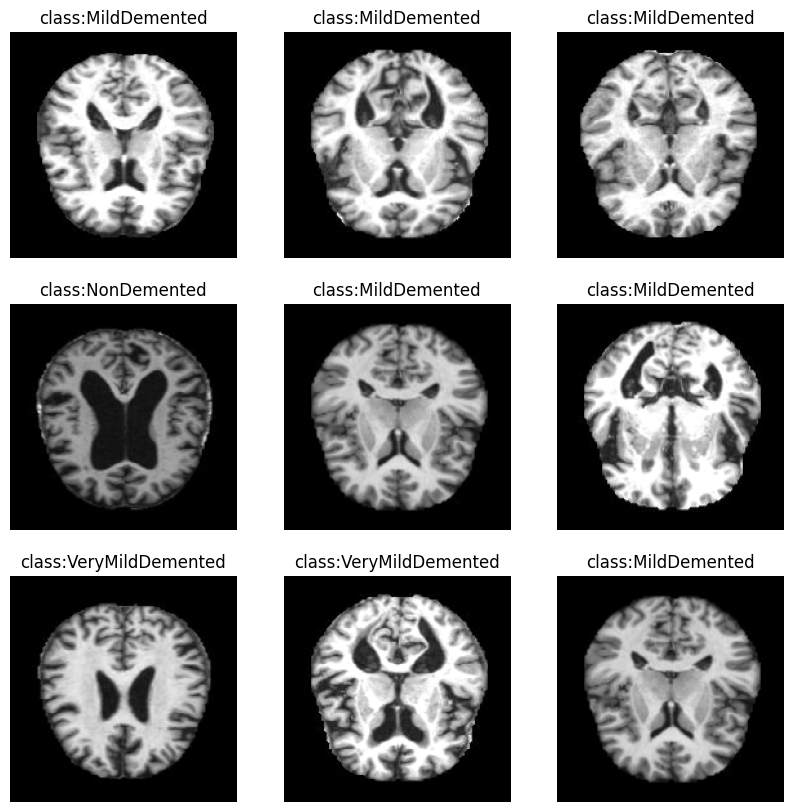

In [7]:
def show_images (generator, y_pred=None):
    labels = dict(zip([0,1,2,3], CLASSES))

    x, y = generator.next() # Helps us getting a lot of images

    # Show a grid of 9 images
    plt.figure(figsize=(10,10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i+1)  # means 3 rows, 3 columns and as i increases the image index also increases
            idx = randint(0, 50)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("class:{}".format(labels[np.argmax(y[idx])]))

    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i+1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])], labels[np.argmax(y_pred[i])]))


# Display the train images:
show_images(train_dataset)

<BarContainer object of 4 artists>

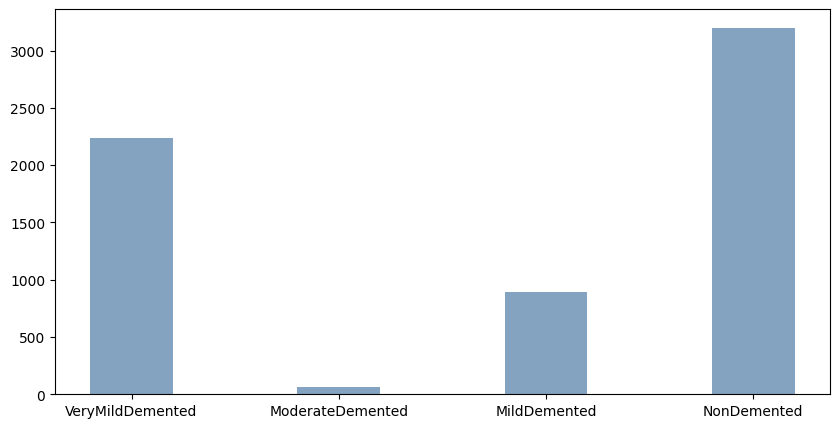

In [8]:
data = {'VeryMildDemented' : 0, 'ModerateDemented' : 0, 'MildDemented' : 0, 'NonDemented' : 0}

# Visualizing dataset
for str in os.listdir(work_dir):
    for img in os.listdir(work_dir + str):
        data[str] = data[str]+1

keys = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize=(10,5))

plt.bar(keys, values, color=(0.2, 0.4, 0.6, 0.6), width=0.4)

In [9]:
train_data, train_labels = train_dataset.next()

In [10]:
print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [11]:
#resampling data

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


In [13]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

### Training Models

### ANN

In [14]:
model = keras.models.Sequential([keras.layers.Flatten(input_shape=[176, 176, 3]),
keras.layers.Dense(100, activation = 'relu'),
keras.layers.Dense(200, activation = 'relu'),
keras.layers.Dense(200, activation = 'relu'),
keras.layers.Dense(200, activation = 'relu'),
keras.layers.Dense(200, activation = 'relu'),
keras.layers.Dense(4, activation = 'softmax')])

In [15]:
callback = keras.callbacks.EarlyStopping(monitor="val_loss",
    patience=3,
    restore_best_weights= True)

In [16]:
model.compile(
    optimizer = keras.optimizers.legacy.Adam(),
    loss = keras.losses.CategoricalCrossentropy(),
    metrics = [keras.metrics.AUC(name='auc')]
)

In [17]:
result = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=25, callbacks=[callback])

Epoch 1/25
164/164 [==============================] - 4s 19ms/step - loss: 1.5431 - auc: 0.6381 - val_loss: 0.9016 - val_auc: 0.8407
Epoch 2/25
164/164 [==============================] - 3s 17ms/step - loss: 0.8745 - auc: 0.8502 - val_loss: 0.7239 - val_auc: 0.8961
Epoch 3/25
164/164 [==============================] - 3s 17ms/step - loss: 0.7563 - auc: 0.8854 - val_loss: 0.8499 - val_auc: 0.8564
Epoch 4/25
164/164 [==============================] - 3s 17ms/step - loss: 0.7653 - auc: 0.8833 - val_loss: 0.6669 - val_auc: 0.9079
Epoch 5/25
164/164 [==============================] - 3s 17ms/step - loss: 0.7237 - auc: 0.8964 - val_loss: 0.8492 - val_auc: 0.8614
Epoch 6/25
164/164 [==============================] - 3s 19ms/step - loss: 0.7091 - auc: 0.9004 - val_loss: 0.8541 - val_auc: 0.8604
Epoch 7/25
164/164 [==============================] - 3s 17ms/step - loss: 0.6642 - auc: 0.9126 - val_loss: 0.6090 - val_auc: 0.9265
Epoch 8/25
164/164 [==============================] - 3s 18ms/step - 

In [18]:
loss, accuracy = model.evaluate(test_data, test_labels)
print("Accuracy: ", accuracy)
print("Loss: ", loss)

52/52 [==============================] - 0s 7ms/step - loss: 0.6180 - auc: 0.9258
Accuracy:  0.925814151763916
Loss:  0.6179546117782593


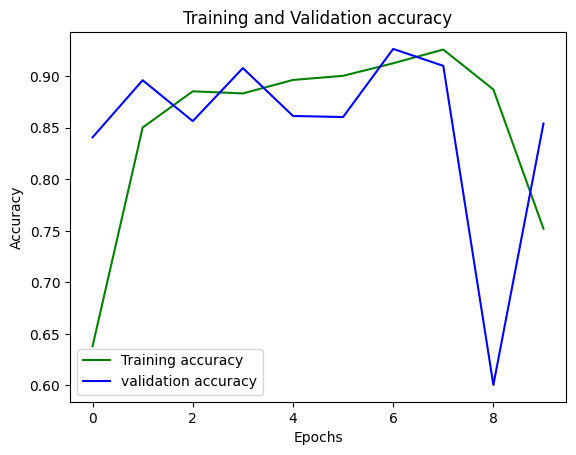

In [19]:
loss_train = result.history['auc']
loss_val = result.history['val_auc']
epochs = range(0, len(loss_train))  # Update the range to match the length of loss_train
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

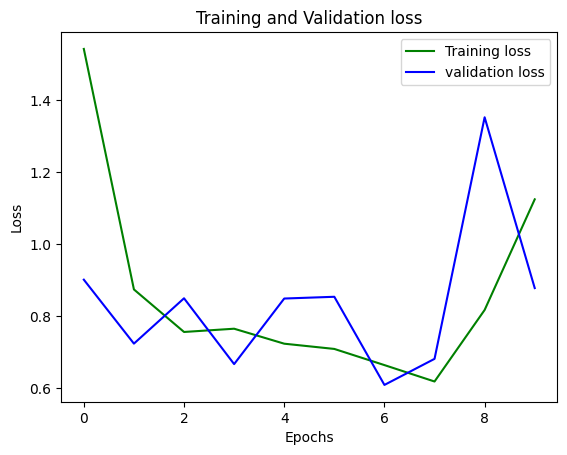

In [20]:
loss_train = result.history['loss']
loss_val = result.history['val_loss']
epochs = range(0, len(loss_train))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### CNN

In [21]:
model = keras.models.Sequential([
keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape = [176,176,3]),
keras.layers.MaxPooling2D(),
keras.layers.Conv2D(32, (2, 2), activation='relu'),
keras.layers.MaxPooling2D(),

keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),

keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.Flatten(),

keras.layers.Dense(512, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.7),

keras.layers.Dense(128, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.5),

keras.layers.Dense(64, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.3),

keras.layers.Dense(4, activation ='softmax')])

In [22]:
model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=[keras.metrics.AUC(name='auc')]
    )

In [23]:
history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=50)

Epoch 1/50
164/164 [==============================] - 36s 213ms/step - loss: 1.7943 - auc: 0.5415 - val_loss: 1.3879 - val_auc: 0.5108
Epoch 2/50
164/164 [==============================] - 40s 245ms/step - loss: 1.4567 - auc: 0.6133 - val_loss: 1.4311 - val_auc: 0.4886
Epoch 3/50
164/164 [==============================] - 41s 248ms/step - loss: 1.2379 - auc: 0.7123 - val_loss: 1.6651 - val_auc: 0.5585
Epoch 4/50
164/164 [==============================] - 36s 222ms/step - loss: 0.9350 - auc: 0.8406 - val_loss: 2.4656 - val_auc: 0.5400
Epoch 5/50
164/164 [==============================] - 34s 206ms/step - loss: 0.8277 - auc: 0.8741 - val_loss: 0.9009 - val_auc: 0.8447
Epoch 6/50
164/164 [==============================] - 34s 208ms/step - loss: 0.7529 - auc: 0.8941 - val_loss: 1.0633 - val_auc: 0.8486
Epoch 7/50
164/164 [==============================] - 35s 211ms/step - loss: 0.7003 - auc: 0.9091 - val_loss: 0.9121 - val_auc: 0.8777
Epoch 8/50
164/164 [==============================] - 3

In [24]:
loss, accuracy = model.evaluate(test_data, test_labels)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

52/52 [==============================] - 3s 61ms/step - loss: 0.7422 - auc: 0.9468
Loss:  0.7422212958335876
Accuracy:  0.9468027353286743


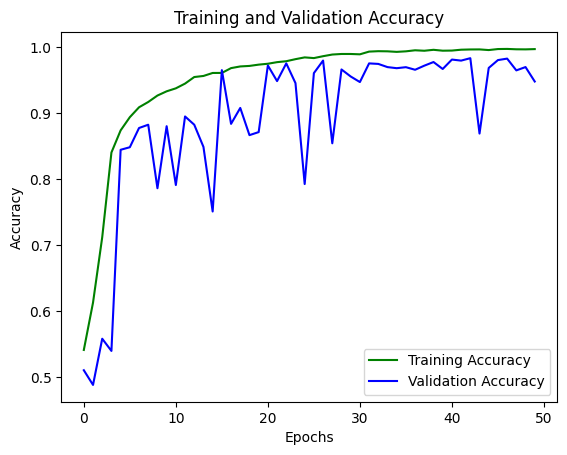

In [25]:
loss_train = history.history['auc']
loss_val = history.history['val_auc']
epochs = range(0,50)
plt.plot(epochs, loss_train, 'g', label = 'Training Accuracy')
plt.plot(epochs, loss_val, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

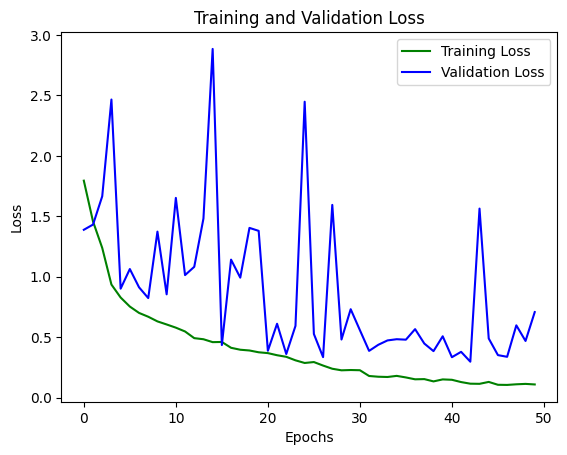

In [26]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,50)
plt.plot(epochs, loss_train, 'g', label = 'Training Loss')
plt.plot(epochs, loss_val, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()